## Setup & Dependencies

In [ ]:
!pip install tqdm
!pip install -U "ray[tune]"
!pip install --user fastai

In [50]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch
import multiprocessing

from fastai.text.all import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import sys
import os

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [3]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

repo_path = "/home/jupyter/src/natalies-little-helper/"
data_path = repo_path + "data/"
model_path = repo_path + "models/"

## Data Preprocessing

In [4]:
train = pd.read_csv(data_path + 'Tweets.csv')
train = train[train['negativereason'].notna()].reset_index(drop=True)
train.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [5]:
train = train[['text', 'negativereason']]

In [6]:
train.groupby('negativereason').head()

,text,negativereason
0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",Bad Flight
1,@VirginAmerica and it's a really big bad thing about it,Can't Tell
2,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,Can't Tell
3,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight
4,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!,Bad Flight
5,@VirginAmerica why are your first fares in May over three times more than other carriers when all seats are available to select???,Can't Tell
6,@VirginAmerica you guys messed up my seating.. I reserved seating with my friends and you guys gave my seat away ... 😡 I want free internet,Customer Service Issue
7,@VirginAmerica status match program. I applied and it's been three weeks. Called and emailed with no response.,Customer Service Issue
8,@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail,Can't Tell
9,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS,Bad Flight


## ULMFiT Utils

In [53]:
def train_lm(train_data, show_batch=False, metrics=[accuracy, Perplexity()], wd=0.1, epochs=(6,6)):
    # Data Loader
    lang_dls = DataBlock(blocks=(TextBlock.from_df('text', is_lm=True)),
                 get_x=ColReader('text'),
                 splitter=RandomSplitter(valid_pct=0.2))
    lang_dls = lang_dls.dataloaders(train_data, bs=64, seq_len=72, device=torch.device('cuda'))
    lang_dls.show_batch(max_n=4)
    
    # Train LM
    learn = language_model_learner(lang_dls, AWD_LSTM, metrics=metrics, wd=wd).to_fp16()
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.85,0.8,0.75))
    
    # Second cycle
    learn.unfreeze()
    lr = learn.lr_find();
    learn.fit_one_cycle(epochs[1], lr.valley, moms=(0.8,0.75,0.7))
    
    return learn, lang_dls
    
def test_lm(learner, text, n_words, n_sentences):
    print("\n".join(learner.predict(text, n_words, temperature=0.75) for _ in range(n_sentences)))
    
def train_classifier(train_data, lang_dls, encoder_path, label, show_batch=False, metrics=[accuracy, Perplexity(), F1Score(average='macro'), F1Score(average='weighted')], wd=0.1, epochs=(4, 4, 9)):
    intent_dls = DataBlock(blocks=(TextBlock.from_df('text', vocab=lang_dls.vocab, seq_len=72), CategoryBlock),
                 get_x=ColReader('text'),
                 get_y=ColReader(label),
                 splitter=RandomSplitter(valid_pct=0.2))

    intent_dls = intent_dls.dataloaders(train_data, bs=64, device=torch.device('cuda'))
    intent_dls.show_batch(max_n=4)
    
    learn = text_classifier_learner(intent_dls, AWD_LSTM, metrics=metrics, wd=wd, drop_mult=0.5).to_fp16()
    learn.load_encoder(encoder_path)
    
    # First cycle
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[0], lr.valley, moms=(0.8,0.75,0.7))
    
    # Second cycle
    learn.freeze_to(-2)
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[1], lr.valley, moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.75,0.7))
    
    # Last cycle
    learn.unfreeze()
    lr = learn.lr_find()
    learn.fit_one_cycle(epochs[2], slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.75,0.7))
    # learn.fit_one_cycle(epochs, lr, moms=(0.8,0.75,0.7))
    
    return learn

def test_classifier_acc(learn):
    pred_fwd,lbl_fwd = learn.get_preds()
    pred_fwd_max = torch.argmax(pred_fwd, dim=1)
    acc = accuracy(pred_fwd, lbl_fwd)
    f1_macro = F1Score(average='macro')(pred_fwd_max, lbl_fwd)
    f1_weighted = F1Score(average='weighted')(pred_fwd_max, lbl_fwd)
    report = classification_report(lbl_fwd, pred_fwd_max)
    print(report)
    return acc, f1_macro, f1_weighted
    

# Language Models

## Clean LMs

### Clean data

In [8]:
all_train = pd.read_csv(data_path + 'Tweets.csv')
# all_train = all_train[all_train['airline_sentiment'].notna()].reset_index(drop=True)
# all_train.airline_sentiment.value_counts()
all_train = all_train[['text', 'airline_sentiment', 'negativereason']]

In [9]:
all_train.head()

,text,airline_sentiment,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,NaN
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,NaN
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,NaN
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,@VirginAmerica and it's a really big bad thing about it,negative,Can't Tell


In [10]:
all_clean_data = all_train.copy()

In [11]:
# Remove HTML tags
all_clean_data['text'] = all_clean_data['text'].apply(lambda x: re.sub(r'<[^<]+?>', ' ', x))

# Remove URLs
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub(r'\s*https?:\/\/\S+(\s+|$)', ' ', x))

# Remove handles
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub("(?<=@)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("@[A-Za-z0-9_]+","", x))

# Remove hashtags
all_clean_data['text'] = all_clean_data['text'].apply(
        # lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    lambda x: re.sub("(?<=#)[A-Za-z0-9_]+","", x))
    # lambda x: re.sub("#[A-Za-z0-9_]+","", x))

# Remove non-alphabetic chars
# all_clean_data['text'] = all_clean_data['text'].apply(
#     lambda x: re.sub(r'[^a-zA-Z\s]+', ' ', x))

# Remove extra spaces
all_clean_data['text'] = all_clean_data['text'].apply(
    lambda x: re.sub(r'\s+', ' ', x))

In [12]:
all_clean_data.head()

,text,airline_sentiment,negativereason
0,@ What @ said.,neutral,NaN
1,@ plus you've added commercials to the experience... tacky.,positive,NaN
2,@ I didn't today... Must mean I need to take another trip!,neutral,NaN
3,"@ it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,Bad Flight
4,@ and it's a really big bad thing about it,negative,Can't Tell


### Full LM

,text,text_
0,xxbos @ st xxrep 4 i l waiting . xxmaj please respond as my flight leaves in 2 1 / 2 hrs xxbos @ xxunk connecting in charlotte to houston . xxmaj mechanical issue xxunk while xxunk to take off . xxmaj and we checked our bags . xxbos @ xxmaj not really . i have a flight to catch at 1 pm in xxmaj vegas . xxmaj i 'm praying i,@ st xxrep 4 i l waiting . xxmaj please respond as my flight leaves in 2 1 / 2 hrs xxbos @ xxunk connecting in charlotte to houston . xxmaj mechanical issue xxunk while xxunk to take off . xxmaj and we checked our bags . xxbos @ xxmaj not really . i have a flight to catch at 1 pm in xxmaj vegas . xxmaj i 'm praying i do
1,". xxmaj flew from xxup psp to xxup phx flight xxunk on 2 / 19 . ( cont ) xxbos @ crazy hold times today . xxmaj over an hour now . xxmaj help ? xxbos @ figured it out 4 flight xxunk . xxmaj hard to believe with xxunk so low , and the killing u make that even part of a hotel ca n't be xxunk xxbos @ we finally","xxmaj flew from xxup psp to xxup phx flight xxunk on 2 / 19 . ( cont ) xxbos @ crazy hold times today . xxmaj over an hour now . xxmaj help ? xxbos @ figured it out 4 flight xxunk . xxmaj hard to believe with xxunk so low , and the killing u make that even part of a hotel ca n't be xxunk xxbos @ we finally just"
2,"what is xxup aa going to do to fix their utterly embarrassing customer service ? xxmaj you wo n't even answer the dang phone ! xxbos @ once he found out we had a problem he xxunk me like the plague . xxmaj was told "" we ca n't find a supervisor . "" xxbos @ is that supposed to change in the near future ? xxbos @ yes . xxmaj hung","is xxup aa going to do to fix their utterly embarrassing customer service ? xxmaj you wo n't even answer the dang phone ! xxbos @ once he found out we had a problem he xxunk me like the plague . xxmaj was told "" we ca n't find a supervisor . "" xxbos @ is that supposed to change in the near future ? xxbos @ yes . xxmaj hung up"
3,that helped me fix my problem were so helpful . # # xxbos @ xxmaj first class service on xxup us 769 xxup phl - mco today from the flight attendant in xxup xxunk i did n't catch her name but she was top notch ! xxbos @ @ click lounges tab . xxmaj need to be flying on xxunk s / a airline xxbos @ flight at 630 from fll kiosk,helped me fix my problem were so helpful . # # xxbos @ xxmaj first class service on xxup us 769 xxup phl - mco today from the flight attendant in xxup xxunk i did n't catch her name but she was top notch ! xxbos @ @ click lounges tab . xxmaj need to be flying on xxunk s / a airline xxbos @ flight at 630 from fll kiosk just


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.692198,4.626140,0.186260,102.119133,00:18
1,4.713428,4.021338,0.265404,55.775684,00:19
2,4.283816,3.907625,0.276612,49.780567,00:18
3,4.066536,3.856394,0.281996,47.294514,00:19
4,3.935900,3.830753,0.284798,46.097218,00:18
5,3.871326,3.818802,0.285772,45.549603,00:18
6,3.834496,3.818293,0.285850,45.526421,00:19


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.755290,3.750540,0.297344,42.544029,00:20
1,3.685080,3.692054,0.303603,40.127193,00:20
2,3.573054,3.654531,0.310244,38.649380,00:20
3,3.473271,3.637123,0.312672,37.982418,00:20
4,3.363131,3.636099,0.313484,37.943535,00:20
5,3.277039,3.641944,0.315081,38.165958,00:20
6,3.202546,3.651132,0.315360,38.518230,00:21
7,3.168075,3.653972,0.315337,38.627777,00:20


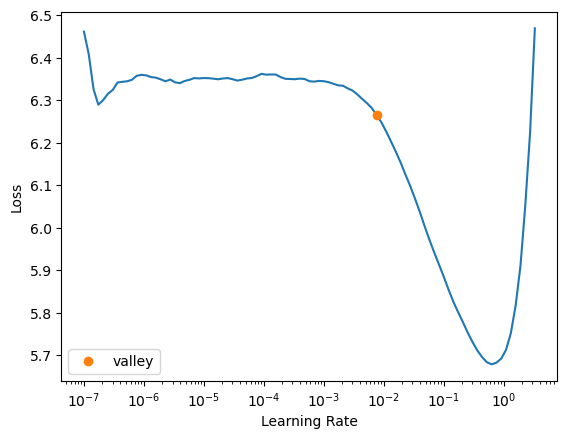

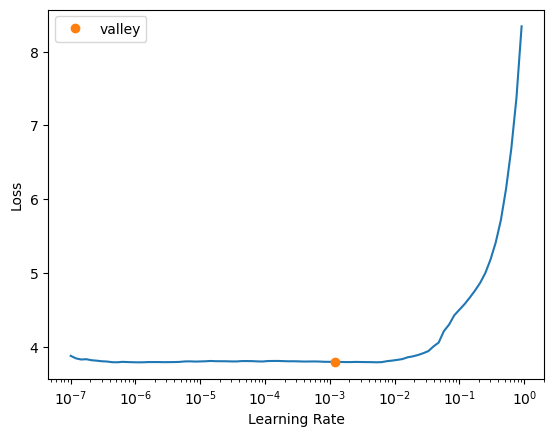

In [13]:
full_lm_clean, full_lang_dls_clean = train_lm(all_clean_data, show_batch=True, epochs=(7,8))

In [14]:
text = 'My flight was delayed'
n_words = 40
n_sentences = 4
test_lm(full_lm_clean, text, n_words, n_sentences)

My flight was delayed a few days because of lack of crew . Flight attendant was rude and helpful . Pls help @ Thank you ! The flight was Cancelled Flightled with no explanation . Thanks
My flight was delayed and moved back to MKE as we sat on the plane . Now a plane is broken . Why should i be put on hold tomorrow ? @ why would n't you have to call back
My flight was delayed for 45 minutes , just after i left the plane . Hope so ! Finally . @ thanks for making my connection to PHL stranded now . Need to go home tomorrow morning , will
My flight was delayed 2 hours because of weather in Boston that were not going to be leaving for tomorrow . No help from mail . @ This is not a terrible experience , to say that , if i


In [15]:
#Save fine-tuned model for future use
acc = 'temp2'
full_lm_clean.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_full_clean_{acc}')

### Negative Sentiment LM

In [16]:
neg_train = all_clean_data[all_clean_data['negativereason'].notna()].reset_index(drop=True)
neg_train.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

,text,text_
0,xxbos @ ah if only we could get through . xxmaj we 've tried for over 2 hrs . xxmaj can we call @ ? xxbos @ served me xxunk xxunk xxunk xxmaj in sauce that xxunk like plastic . xxmaj do you have any food for human xxunk anymore ? xxbos @ hour 4 at the gate . xxbos @ how do you xxup not do maintenance on # while it,@ ah if only we could get through . xxmaj we 've tried for over 2 hrs . xxmaj can we call @ ? xxbos @ served me xxunk xxunk xxunk xxmaj in sauce that xxunk like plastic . xxmaj do you have any food for human xxunk anymore ? xxbos @ hour 4 at the gate . xxbos @ how do you xxup not do maintenance on # while it sits
1,"a full refund . xxmaj please confirm when we will receive . xxbos @ xxmaj its the abc 's of xxup pr , let your customers have the most info possible . xxmaj might want to go xxunk up on the xxunk … xxbos @ xxmaj asked for a xxunk of a change fee for flight booked w / in past 24 hrs . xxmaj rep was rude . xxmaj just told","full refund . xxmaj please confirm when we will receive . xxbos @ xxmaj its the abc 's of xxup pr , let your customers have the most info possible . xxmaj might want to go xxunk up on the xxunk … xxbos @ xxmaj asked for a xxunk of a change fee for flight booked w / in past 24 hrs . xxmaj rep was rude . xxmaj just told me"
2,virgin in with the others now . xxup bos weather has xxunk their actual xxmaj xxunk xxmaj serv model . xxmaj never xxmaj flight xxmaj booking xxmaj problems with xxmaj virgin again ! xxbos @ so we have a xxmaj cancelled xxmaj flightled flight in about twelve hours . xxmaj maybe we 'll have heard from an xxup aa rep at that point . xxbos @ @ why do n't you tweet,in with the others now . xxup bos weather has xxunk their actual xxmaj xxunk xxmaj serv model . xxmaj never xxmaj flight xxmaj booking xxmaj problems with xxmaj virgin again ! xxbos @ so we have a xxmaj cancelled xxmaj flightled flight in about twelve hours . xxmaj maybe we 'll have heard from an xxup aa rep at that point . xxbos @ @ why do n't you tweet canned
3,- iced . xxmaj why was n't this done when the planes were sitting out all night ? xxbos @ xxmaj it 's the rude and arrogant gate personnel . xxmaj xxunk for . xxmaj unprofessional . # xxbos @ xxunk marketing practices promised me if i booked flights i would xxunk my status now they are not xxunk . xxmaj xxunk xxbos @ ca n't speak with customer service for 2hours,"iced . xxmaj why was n't this done when the planes were sitting out all night ? xxbos @ xxmaj it 's the rude and arrogant gate personnel . xxmaj xxunk for . xxmaj unprofessional . # xxbos @ xxunk marketing practices promised me if i booked flights i would xxunk my status now they are not xxunk . xxmaj xxunk xxbos @ ca n't speak with customer service for 2hours ,"


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.829387,4.852834,0.176906,128.102890,00:13
1,4.929679,4.060989,0.255674,58.031670,00:12
2,4.451473,3.940714,0.268442,51.455345,00:12
3,4.189825,3.880156,0.274286,48.431759,00:12
4,4.035669,3.853279,0.276247,47.147411,00:13
5,3.935581,3.841217,0.277565,46.582134,00:12
6,3.888230,3.839982,0.277419,46.524639,00:12


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.826788,3.821189,0.280402,45.658459,00:13
1,3.791806,3.779000,0.286087,43.772259,00:13
2,3.745351,3.746160,0.294350,42.358093,00:13
3,3.705792,3.729481,0.297159,41.657482,00:13
4,3.671417,3.717684,0.298686,41.168938,00:14
5,3.639946,3.713662,0.299203,41.003693,00:13
6,3.620943,3.711798,0.299783,40.927334,00:13
7,3.612976,3.711751,0.299495,40.925404,00:13


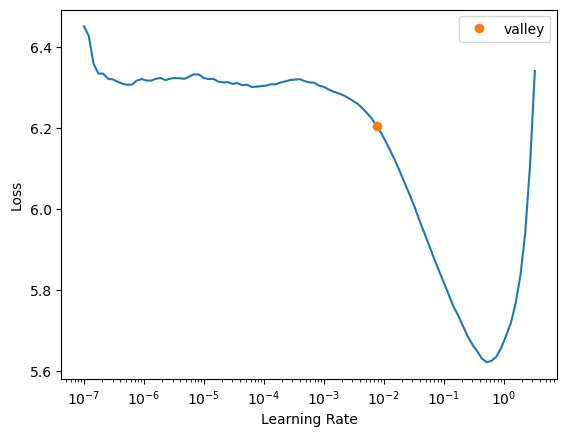

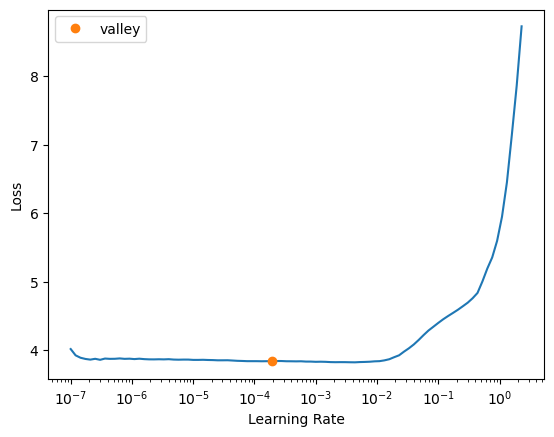

In [17]:
full_lm_neg, lang_dls_neg = train_lm(neg_train, show_batch=True, epochs=(7,8))

In [18]:
text = 'My flight was delayed'
n_words = 40
n_sentences = 4
test_lm(full_lm_neg, text, n_words, n_sentences)

My flight was delayed for 2 hours after landing . No one else . Thank you for the bad experience ! @ I 've been on hold for over an hour , i 've been on hold for over an
My flight was delayed Cancelled Flightled after 2 hours and no one is answering the phone . Flight Cancelled Flightled . Is there a way to get through for another flight ? @ Is there a
My flight was delayed for over an hour . Your team was on the plane for over two hours . My flight was delayed till Wednesday . This is such a disaster . @ thanks . My reservation
My flight was delayed and now we still need to stay in Vegas to hope we were on Tarmac … Still no way to speak to someone @ what is happening with Tuesday ? What is the reason


In [19]:
#Save fine-tuned model for future use
acc = 'temp2'
full_lm_neg.save_encoder(f'{model_path}ULMFiT_fine_tuned_LM_neg_{acc}')

# Intents Full LM

## Sub Groups

In [20]:
intentSubGroups = {
    'Customer Service Issue': 'Customer Service Issue',
    'Late Flight': 'Late Flight',
    'Cancelled Flight': 'Cancelled Flight',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Bad Flight',
    'Flight Booking Problems': 'Flight Booking Problems',
    'Flight Attendant Complaints': 'Flight Attendant Complaints',
    'longlines': 'Customer Service Issue',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

neg_train['intentGroup'] = neg_train.negativereason.apply(lambda x: intentSubGroups[x])

### Train Classifier

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,Bad Flight
2,"xxbos @ i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",Late Flight
3,xxbos @ xxup poor xxup experience 2day at ord xxunk . 8 xxunk . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,Customer Service Issue


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.542084,1.308896,0.581471,3.702085,0.518708,0.580477,00:03
1,1.336969,1.227793,0.586921,3.413686,0.516721,0.577605,00:04
2,1.208192,1.180005,0.593461,3.254391,0.515085,0.584179,00:04
3,1.150723,1.183313,0.587466,3.265175,0.507592,0.574554,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.134568,1.177085,0.590191,3.244900,0.514857,0.579993,00:04
1,1.125952,1.177229,0.591281,3.245368,0.517731,0.580936,00:04
2,1.124567,1.170138,0.590191,3.222437,0.513635,0.578443,00:04
3,1.106535,1.180263,0.589101,3.255229,0.512738,0.575896,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.098758,1.169774,0.600000,3.221265,0.528759,0.590514,00:05
1,1.105080,1.153182,0.609264,3.168257,0.547629,0.602895,00:05
2,1.035596,1.119162,0.619619,3.062288,0.556231,0.615145,00:05
3,0.957480,1.089990,0.636512,2.974244,0.570601,0.630137,00:05
4,0.867011,1.102728,0.629973,3.012374,0.573590,0.626703,00:05
5,0.755668,1.131485,0.632153,3.100255,0.565979,0.626310,00:05
6,0.693841,1.122358,0.631608,3.072091,0.573737,0.628957,00:05
7,0.657191,1.122928,0.634877,3.073841,0.570844,0.628046,00:05
8,0.629263,1.125920,0.636512,3.083053,0.581767,0.633332,00:06


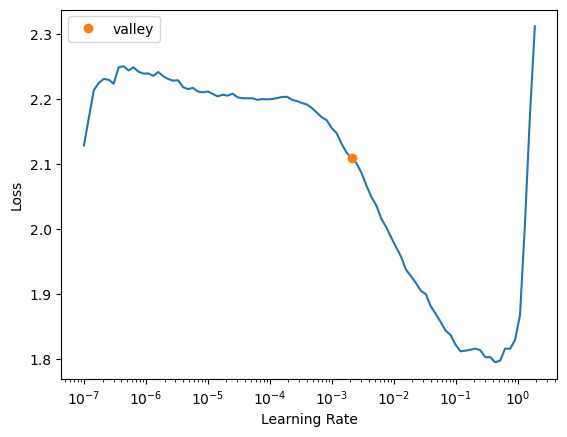

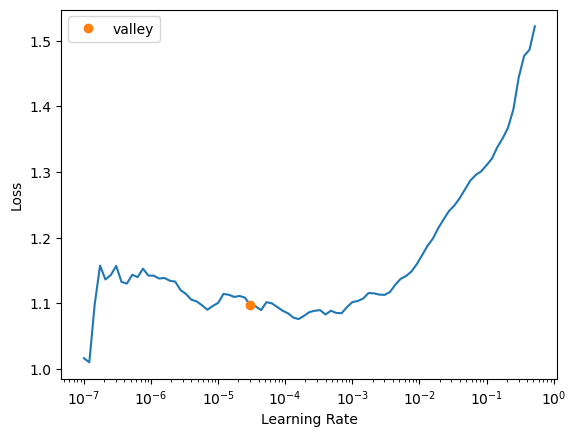

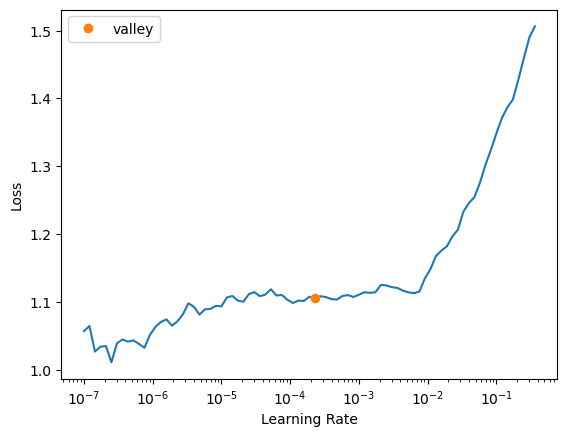

In [22]:
acc = 'temp2'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
intent_classifier = train_classifier(neg_train, full_lang_dls_clean, encoder_path, label='intentGroup')

In [57]:
# pred_fwd,lbl_fwd = intent_classifier.get_preds()
# print(pred_fwd.shape)
# print(lbl_fwd.shape)
# print(pred_fwd[0])
# print(lbl_fwd[0])
# print(torch.argmax(pred_fwd, dim=1)[0])
# print(intent_classifier.metrics[3](torch.argmax(pred_fwd, dim=1), lbl_fwd))
# print(intent_classifier.metrics[3](lbl_fwd,torch.argmax(pred_fwd, dim=1)))
# report = classification_report(lbl_fwd,torch.argmax(pred_fwd, dim=1))
# print(report)

In [58]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_classifier)
print(acc, f1_macro, f1_weighted)

              precision    recall  f1-score   support

           0       0.67      0.45      0.53       130
           1       0.45      0.45      0.45       229
           2       0.74      0.65      0.69       176
           3       0.71      0.74      0.72       635
           4       0.53      0.36      0.43        86
           5       0.43      0.46      0.45        97
           6       0.62      0.72      0.67       329
           7       0.70      0.73      0.72       153

    accuracy                           0.64      1835
   macro avg       0.61      0.57      0.58      1835
weighted avg       0.64      0.64      0.63      1835

TensorBase(0.6365) 0.5817665224111952 0.6333318605253354


In [59]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_classifier)
intent_classifier.save(f'{model_path}ULMFiT_intent_full_class_subgroup_{acc.item()}')

              precision    recall  f1-score   support

           0       0.67      0.45      0.53       130
           1       0.45      0.45      0.45       229
           2       0.74      0.65      0.69       176
           3       0.71      0.74      0.72       635
           4       0.53      0.36      0.43        86
           5       0.43      0.46      0.45        97
           6       0.62      0.72      0.67       329
           7       0.70      0.73      0.72       153

    accuracy                           0.64      1835
   macro avg       0.61      0.57      0.58      1835
weighted avg       0.64      0.64      0.63      1835



Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_subgroup_0.636512279510498.pth')

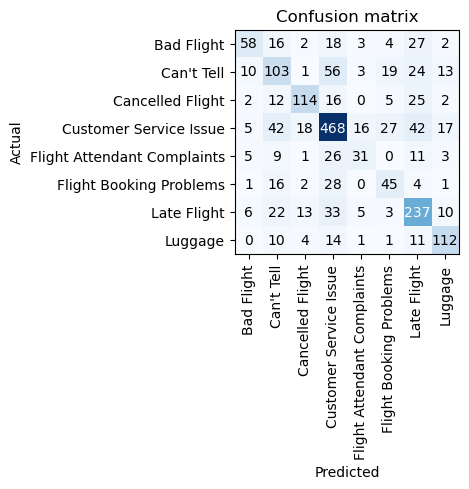

In [60]:
interp = ClassificationInterpretation.from_learner(intent_classifier)
interp.plot_confusion_matrix()

In [61]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_classifier.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([1.8123e-04, 1.6201e-03, 9.0298e-01, 3.3803e-02, 2.7473e-04, 6.0614e-02,
         2.6473e-04, 2.5961e-04]))

In [62]:
# all_clean_data['intent_pred'] = all_clean_data['text'].apply(lambda x: intent_classifier.predict(x))

### Train Sampled Classifier

In [63]:
neg_train_sampled = neg_train.groupby('intentGroup').apply(lambda x: x.sample(min(750, len(x)))).reset_index(drop=True)

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,xxbos @ xxup xxunk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup xxunk xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup xxunk u xxup and,Bad Flight
2,xxbos @ @ 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over xxrep 3 !,Flight Booking Problems
3,"xxbos @ xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",Flight Booking Problems


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.581681,1.338479,0.547753,3.813241,0.527337,0.536785,00:03
1,1.389102,1.287899,0.577715,3.625161,0.561069,0.572531,00:03
2,1.264198,1.258395,0.584270,3.519768,0.568126,0.578454,00:02
3,1.182763,1.263362,0.580524,3.537295,0.563068,0.573957,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.134923,1.252740,0.587079,3.499921,0.572676,0.582115,00:03
1,1.137633,1.271547,0.576779,3.566367,0.557590,0.568886,00:03
2,1.121814,1.253712,0.585206,3.503323,0.569463,0.579543,00:03
3,1.122712,1.251755,0.591760,3.496475,0.576533,0.585771,00:03


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.136494,1.250974,0.585206,3.493743,0.570214,0.580095,00:04
1,1.104070,1.251397,0.596442,3.495221,0.583111,0.592447,00:03
2,1.013736,1.217428,0.598315,3.378487,0.586083,0.594778,00:03
3,0.917741,1.218833,0.592697,3.383237,0.579813,0.588239,00:03
4,0.845740,1.218610,0.601124,3.382483,0.586568,0.595982,00:03


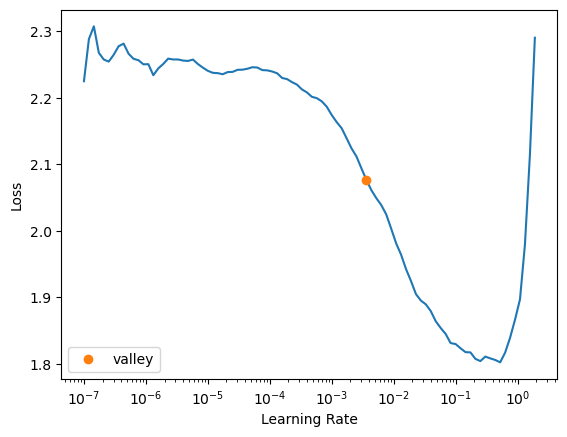

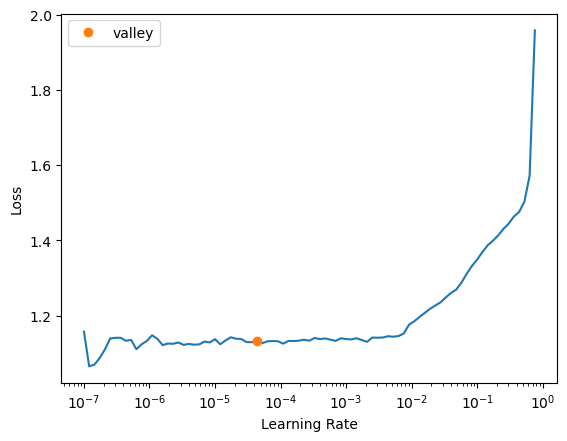

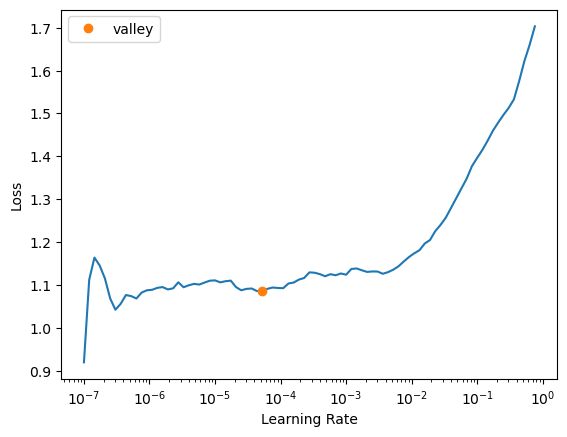

In [65]:
acc = 'temp2'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
epochs = (4, 4, 5)
intent_sampled_classifier = train_classifier(neg_train_sampled, full_lang_dls_clean, encoder_path, label='intentGroup', epochs=epochs)

In [66]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_sampled_classifier)
print(acc)

              precision    recall  f1-score   support

           0       0.51      0.50      0.51       123
           1       0.52      0.42      0.46       159
           2       0.76      0.79      0.77       150
           3       0.57      0.53      0.55       138
           4       0.57      0.44      0.49        94
           5       0.51      0.58      0.54        92
           6       0.58      0.70      0.63       161
           7       0.70      0.77      0.74       151

    accuracy                           0.60      1068
   macro avg       0.59      0.59      0.59      1068
weighted avg       0.60      0.60      0.60      1068

TensorBase(0.6011)


In [67]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_sampled_classifier)
intent_sampled_classifier.save(f'{model_path}ULMFiT_intent_full_class_subgroup_sample_{acc.item()}')

              precision    recall  f1-score   support

           0       0.51      0.50      0.51       123
           1       0.52      0.42      0.46       159
           2       0.76      0.79      0.77       150
           3       0.57      0.53      0.55       138
           4       0.57      0.44      0.49        94
           5       0.51      0.58      0.54        92
           6       0.58      0.70      0.63       161
           7       0.70      0.77      0.74       151

    accuracy                           0.60      1068
   macro avg       0.59      0.59      0.59      1068
weighted avg       0.60      0.60      0.60      1068



Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_subgroup_sample_0.601123571395874.pth')

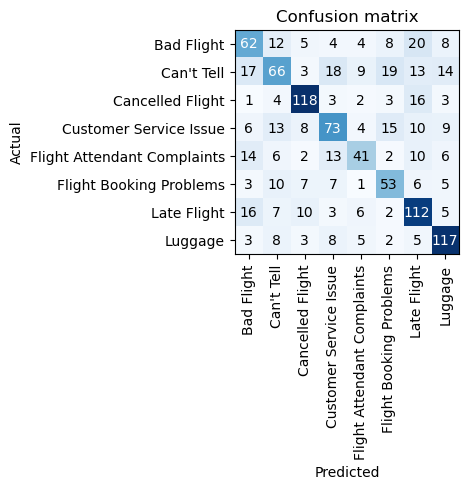

In [68]:
interp = ClassificationInterpretation.from_learner(intent_sampled_classifier)
interp.plot_confusion_matrix()

In [69]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_sampled_classifier.predict(text)

('Cancelled Flight',
 tensor(2),
 tensor([2.4412e-04, 1.9991e-03, 9.0565e-01, 3.8417e-02, 2.3661e-04, 5.2305e-02,
         9.0259e-04, 2.4796e-04]))

In [70]:
# all_clean_data['intent_sampled_pred'] = all_clean_data['text'].apply(lambda x: intent_sampled_classifier.predict(x))

## Master Groups

In [71]:
intentMasterGroups = {
    'Customer Service Issue': 'Customer Service',
    'Late Flight': 'Flights',
    'Cancelled Flight': 'Flights',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Flights',
    'Flight Booking Problems': 'Customer Service',
    'Flight Attendant Complaints': 'Customer Service',
    'longlines': 'Customer Service',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

neg_train['intentMasterGroups'] = neg_train.negativereason.apply(lambda x: intentMasterGroups[x])

### Train Classifier

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,"xxbos @ i ❤ ️ xxmaj jetblue but i was on flt xxunk from fll to sfo . xxunk off was over 1 hr xxmaj late xxmaj flight , div to phx & & got in 2 hrs xxmaj late xxmaj flight . xxmaj what will be done ?",Flights
2,"xxbos @ xxup xxunk from xxup ric , xxup xxunk from xxup ord , & & xxup xxunk from xxup den xxunk xxup delayed for non - weather issues . xxmaj way to go , you re batting 1 . xxrep 3 0 ! xxmaj but no hotels",Flights
3,"xxbos .@ ( 2 / 3 ) … i sat on the runway for 4 xxup more xxup hrs b4 takeoff ( 10 hrs xxmaj late xxmaj flight , xxunk xxup am ) . xxmaj pilot xxunk stated it was a comp / mech issue .",Flights


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.065920,0.898869,0.659945,2.456822,0.594022,0.659530,00:04
1,0.919912,0.794766,0.690463,2.213924,0.612680,0.679971,00:04
2,0.821691,0.755383,0.698093,2.128427,0.625485,0.687282,00:04
3,0.786993,0.743036,0.702997,2.102309,0.629627,0.691487,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,0.766338,0.742361,0.710082,2.100890,0.629722,0.693871,00:04
1,0.752859,0.747334,0.706812,2.111364,0.632720,0.694896,00:04
2,0.749900,0.742846,0.707902,2.101910,0.640473,0.698621,00:04
3,0.752372,0.741865,0.705722,2.099849,0.632294,0.693748,00:04


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,0.739740,0.736483,0.702452,2.088578,0.622674,0.687391,00:06
1,0.744761,0.706777,0.718256,2.027446,0.644901,0.704105,00:06
2,0.693870,0.690674,0.724796,1.995060,0.659026,0.711902,00:06
3,0.638685,0.696021,0.731880,2.005755,0.663960,0.718167,00:06
4,0.554611,0.683055,0.736240,1.979918,0.673614,0.724754,00:06
5,0.497930,0.707572,0.731880,2.029059,0.676284,0.723983,00:05
6,0.436906,0.707753,0.742779,2.029426,0.683598,0.733830,00:05
7,0.398255,0.707663,0.733515,2.029243,0.680022,0.726940,00:06
8,0.390628,0.707395,0.736240,2.028699,0.682862,0.729894,00:05


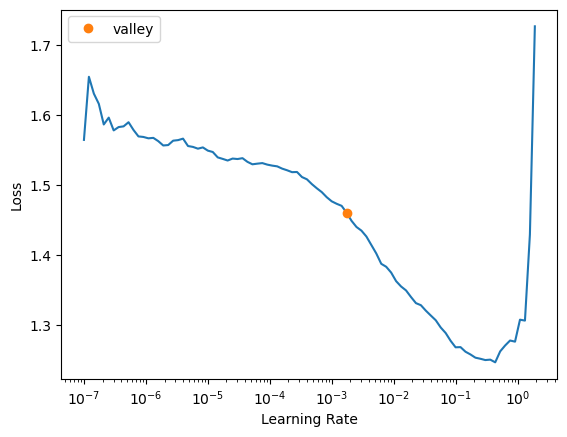

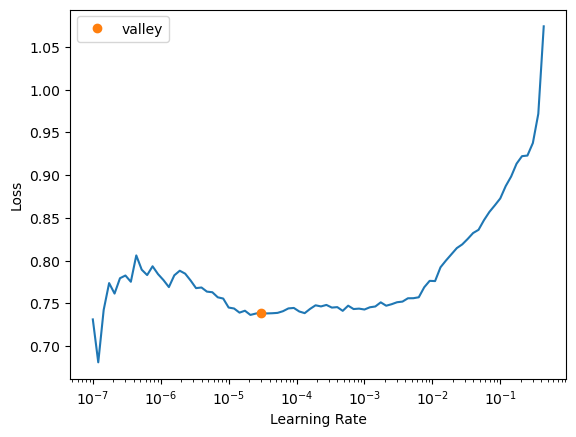

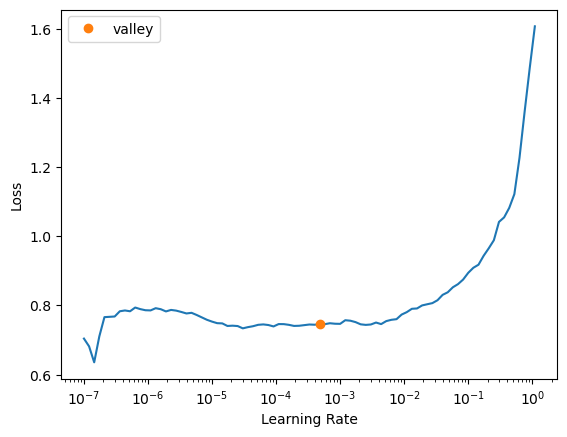

In [72]:
acc = 'temp2'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
intent_master_classifier = train_classifier(neg_train, full_lang_dls_clean, encoder_path, label='intentMasterGroups')

In [73]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_master_classifier)
print(acc)

              precision    recall  f1-score   support

           0       0.49      0.35      0.41       229
           1       0.77      0.79      0.78       849
           2       0.74      0.80      0.77       606
           3       0.79      0.75      0.77       151

    accuracy                           0.74      1835
   macro avg       0.70      0.67      0.68      1835
weighted avg       0.73      0.74      0.73      1835

TensorBase(0.7362)


In [74]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_master_classifier)
intent_master_classifier.save(f'{model_path}ULMFiT_intent_full_class_mastergroup_{acc.item()}')

              precision    recall  f1-score   support

           0       0.49      0.35      0.41       229
           1       0.77      0.79      0.78       849
           2       0.74      0.80      0.77       606
           3       0.79      0.75      0.77       151

    accuracy                           0.74      1835
   macro avg       0.70      0.67      0.68      1835
weighted avg       0.73      0.74      0.73      1835



Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_mastergroup_0.7362397909164429.pth')

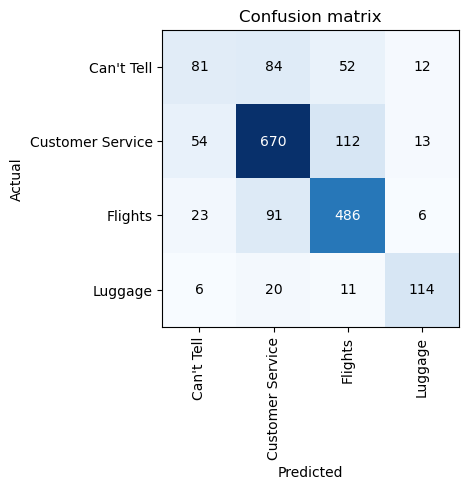

In [75]:
interp = ClassificationInterpretation.from_learner(intent_master_classifier)
interp.plot_confusion_matrix()

In [76]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_master_classifier.predict(text)

('Flights',
 tensor(2),
 tensor([8.0775e-04, 1.6693e-01, 8.3214e-01, 1.3109e-04]))

In [77]:
# all_clean_data['intent_mastergroup_pred'] = all_clean_data['text'].apply(lambda x: intent_master_classifier.predict(x))

### Train Sampled Classifier

In [78]:
neg_train_master_sampled = neg_train.groupby('intentMasterGroups').apply(lambda x: x.sample(min(1000, len(x)))).reset_index(drop=True)

,text,category
0,xxbos @ xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag xxrep 3 ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup xxunk m,Luggage
1,"xxbos @ xxmaj hey , xxup aa ! xxmaj there was a mistake made by your xxup cr on my xxmaj flight xxmaj booking xxmaj problems . xxmaj when i call your reservations # , i keep getting hung up on . xxmaj advise .",Customer Service
2,xxbos @ no delay . i pay $ xxrep 3 7 xxunk for xxup bs xxup a1 ticket . xxmaj you boarded flight early . xxmaj i 'm last to board . xxmaj now have middle seat . xxmaj wasted xxrep 4 $ !,Flights
3,"xxbos @ xxmaj customer service is dead . xxmaj last xxunk , flts delayed / xxmaj cancelled xxmaj flighted . xxmaj bags lost 4 days . xxmaj last nt , flt delayed / xxmaj cancelled xxmaj flighted . xxmaj no meal voucher ?",Customer Service


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,1.168400,0.927343,0.644269,2.527783,0.644147,0.641502,00:02
1,1.011833,0.880700,0.638999,2.412587,0.639993,0.636126,00:03
2,0.923809,0.860689,0.657444,2.364791,0.659059,0.655975,00:03
3,0.875322,0.865917,0.657444,2.377184,0.656793,0.653782,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,0.848858,0.863393,0.660079,2.371192,0.661132,0.657932,00:02
1,0.838044,0.859304,0.660079,2.361516,0.661396,0.657936,00:02
2,0.831205,0.860973,0.664032,2.365460,0.664994,0.662083,00:02
3,0.823512,0.861250,0.657444,2.366117,0.658703,0.655323,00:02


epoch,train_loss,valid_loss,accuracy,perplexity,f1_score,f1_score,time
0,0.842472,0.845318,0.648221,2.328717,0.651440,0.647998,00:03
1,0.827054,0.829170,0.678524,2.291417,0.680733,0.676412,00:03
2,0.754511,0.798967,0.689065,2.223244,0.690925,0.687154,00:03
3,0.674844,0.799820,0.703557,2.225140,0.706240,0.703212,00:03
4,0.616618,0.805618,0.700922,2.238080,0.702601,0.698803,00:03


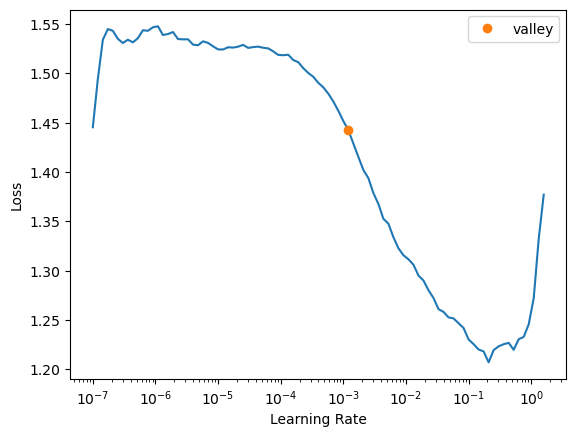

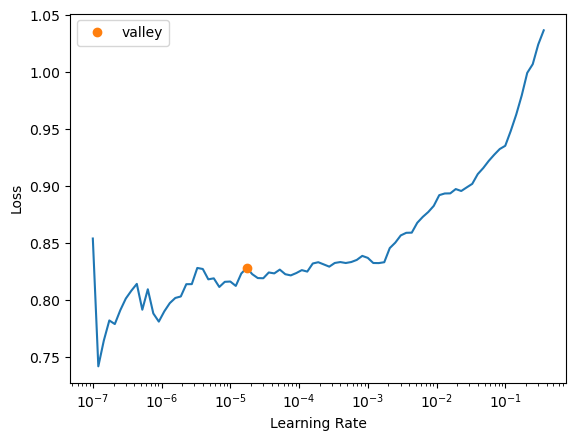

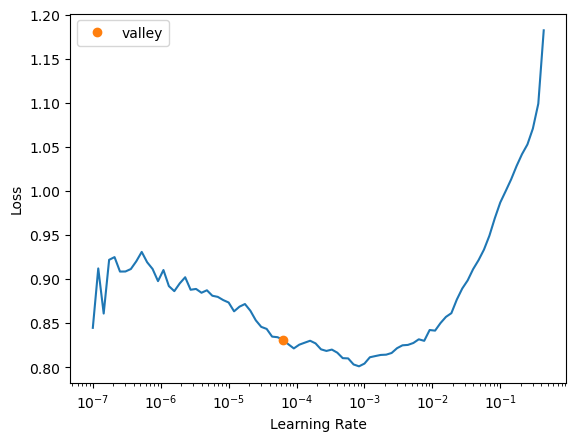

In [79]:
acc = 'temp2'
encoder_path = model_path + f'ULMFiT_fine_tuned_LM_full_clean_{acc}'
epochs = (4, 4, 5)
intent_master_sampled_classifier = train_classifier(neg_train_master_sampled, full_lang_dls_clean, encoder_path, label='intentMasterGroups', epochs=epochs)

In [80]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_master_sampled_classifier)
print(acc)

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       189
           1       0.68      0.61      0.65       201
           2       0.71      0.75      0.73       204
           3       0.78      0.84      0.81       165

    accuracy                           0.70       759
   macro avg       0.70      0.71      0.70       759
weighted avg       0.70      0.70      0.70       759

TensorBase(0.7009)


In [81]:
acc, f1_macro, f1_weighted = test_classifier_acc(intent_master_sampled_classifier)
intent_master_sampled_classifier.save(f'{model_path}ULMFiT_intent_full_class_matergroup_sample_{acc.item()}')

              precision    recall  f1-score   support

           0       0.63      0.62      0.63       189
           1       0.68      0.61      0.65       201
           2       0.71      0.75      0.73       204
           3       0.78      0.84      0.81       165

    accuracy                           0.70       759
   macro avg       0.70      0.71      0.70       759
weighted avg       0.70      0.70      0.70       759



Path('/home/jupyter/src/natalies-little-helper/models/ULMFiT_intent_full_class_matergroup_sample_0.7009222507476807.pth')

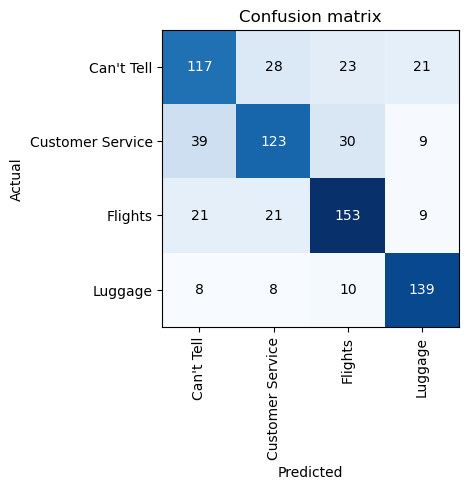

In [82]:
interp = ClassificationInterpretation.from_learner(intent_master_sampled_classifier)
interp.plot_confusion_matrix()

In [83]:
text = '@VirginAmerica How do I reschedule my Cancelled Flightled flights online? The change button is greyed out!'
intent_master_sampled_classifier.predict(text)

('Flights', tensor(2), tensor([0.0102, 0.1783, 0.8070, 0.0045]))

In [84]:
# all_clean_data['intent_sampled_pred'] = all_clean_data['text'].apply(lambda x: intent_sampled_classifier.predict(x))

## Store Models

In [ ]:
print(os.getcwd())

In [ ]:
intent_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_classifier.export('intent_classifier.pkl')

In [ ]:
intent_sampled_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_sampled_classifier.export('intent_sampled_classifier.pkl')

In [ ]:
intent_master_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_master_classifier.export('intent_master_classifier.pkl')

In [ ]:
intent_master_sampled_classifier.path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
intent_master_sampled_classifier.export('intent_master_sampled_classifier.pkl')

## Access Models

In [ ]:
path = (Path(os.getcwd())).parent.absolute() / 'models' / 'ULMFiT' / 'final'
model_name = 'intent_classifier.pkl'
learn = load_learner(path / model_name)

In [ ]:
learn.predict(text)

In [ ]:
learner = helper.load_ulmfit_classifier('intent_groups')
learner.predict(text)